# Import libraries

In [3]:

import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import numpy as np
# computations for coens d
from statistics import mean, stdev
from math import sqrt

# Change parameters of the Figure size for sure
matplotlib.rcParams.update({'font.size': 15})
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 13
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size    


In [4]:

# Change parameters of the Figure size for sure (need to be done twice)

matplotlib.rcParams.update({'font.size': 15})
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 13
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size    


# Plot function

In [5]:


def box_stripe_plot(feature_1,feature_2,label_1,label_2,title):
    
    # make a dataframe
    my_data = pd.DataFrame({label_1: pd.Series(feature_1), label_2: pd.Series(feature_2)})
    my_data.head()
    
    # plot box and stripplot together
    sns.boxplot(data = my_data.iloc[:,:],palette="Set2",fliersize=0)
    sns.stripplot(data = my_data.iloc[:,:],jitter=True,palette="Set2", split=True,linewidth=1,edgecolor='gray')
    plt.ylabel('F-I curve gain (Hz/pA)')
    plt.title(title)


# Load the data

In [6]:

# load the csv's
stim = pd.read_csv('./Data/WG4/spikes.csv', delimiter = ' ', header = None)
stim_3ch = pd.read_csv('./Data/WG4_3_altered/spikes.csv', delimiter = ' ', header = None)
stim_BK = pd.read_csv('./Data/WG4_BK/spikes.csv', delimiter = ' ', header = None)
stim_Cav22 = pd.read_csv('./Data/WG4_Cav22/spikes.csv', delimiter = ' ', header = None)
stim_Kir21 = pd.read_csv('./Data/WG4_Kir21/spikes.csv', delimiter = ' ', header = None)


# Process spikes

In [7]:

def plot_rate_spike_time(stim,to_plot=False):
    # this function takes the stimulation dataframe
    # and returns the vector of currents and rates
    
    # THIS VALUE IS NOT USED!
    n_neurons = len(np.unique(stim[1].values))

    # number of spikes between 500 and 1500 ms
    
    # list of all stimulation parts
    stim_parts=[]
    # assemble the whole list
    stim_parts.append(stim.loc[ (stim[0]>500) & (stim[0]<1500) ])
    stim_parts.append(stim.loc[ (stim[0]>2000) & (stim[0]<3000) ])
    stim_parts.append(stim.loc[ (stim[0]>3500) & (stim[0]<4500) ])
    stim_parts.append(stim.loc[ (stim[0]>5000) & (stim[0]<6000) ])
    stim_parts.append(stim.loc[ (stim[0]>6500) & (stim[0]<7500) ])
    stim_parts.append(stim.loc[ (stim[0]>8000) & (stim[0]<9000) ])
    stim_parts.append(stim.loc[ (stim[0]>9500) & (stim[0]<10500) ])
    stim_parts.append(stim.loc[ (stim[0]>11000) & (stim[0]<12000) ])
    stim_parts.append(stim.loc[ (stim[0]>12500) & (stim[0]<13500) ])
    stim_parts.append(stim.loc[ (stim[0]>14000) & (stim[0]<15000) ])
    # list of stimulation times
    stim_times=[500,2000,3500,5000,6500,8000,9500,11000,12500,14000]

    # lists to save the time to spike
    rates_mean=[]
    rates_std=[]
    time_to_spike_mean=[]
    time_to_spike_std=[]
    all_rates=np.zeros((12,10))
    
    # dictionary to store the neuron rates
    neuron_rates=dict()

    # compute rates and std
    for i in range(len(stim_parts)):

        # lists to store time to spike
        rates=[]
        time_to_spike=[]

        # cut the dataframe
        stim_part = stim_parts[i]

        # get the set of unique neurons
        #unique_neurons = np.unique(stim_part[1].values)
        
        # hard-code unique neurons
        unique_neurons = np.array([41, 83, 125, 167, 209, 251, 273, 335, 377, 419, 461, 499])

        # go over the whole range of unique neurons!
        for j in range(len(unique_neurons)):
            # if the neuron is a Granule cell
            if unique_neurons[j] < 500:
                small_part = stim_part.loc[stim_part[1] == unique_neurons[j]]
                rate=len(small_part)
                # check if there are no spikes
                if small_part[0].values != []:
                    t_spike = np.min(small_part[0].values) - stim_times[i]
                else:
                    t_spike = 0
                    
                # safe times
                rates.append(rate)
                time_to_spike.append(t_spike)
                # safe the neuron rate to the dictionary
                if unique_neurons[j] in neuron_rates:
                    neuron_rates[unique_neurons[j]].append(rate)
                else:
                    neuron_rates[unique_neurons[j]]=[rate]
        # record all rates to array
        all_rates[:,i]=rates
        # record the current rates
        rates_mean.append(np.mean(rates))
        # compute std or standard error
        #rates_std.append(np.std(rates))
        rates_std.append(stats.sem(rates))
        time_to_spike_mean.append(np.mean(time_to_spike))
        #time_to_spike_std.append(np.std(time_to_spike))
        time_to_spike_std.append(stats.sem(time_to_spike))

        
    # input currents
    currents = [100,200,300,400,500,600,700,800,900,1000]
    
    
    # compute f-I curves
    fi_gains=[]
    for key in neuron_rates:
        x=currents
        y=neuron_rates[key]
        # linear fit
        A = np.vstack([x, np.ones(len(y))]).T
        m, c = np.linalg.lstsq(A, y)[0]
        fi_gains.append(m)

    if to_plot == True:
        
        # rates plot
        plt.figure(1)
        plt.errorbar(currents,time_to_spike_mean,time_to_spike_std)
        plt.xlabel('Injected current (pA)')
        plt.ylabel('Time to spike (ms)')
        
        # current plot
        plt.figure(2)
        plt.errorbar(currents,rates_mean,rates_std)
        plt.xlabel('Injected current (pA)')
        plt.ylabel('Firing rate (Hz)')
        
    return currents, all_rates, rates_mean, rates_std, time_to_spike_mean, time_to_spike_std, fi_gains


# Compute F-I curves

In [14]:

# compute fI curves for different populations
stim_curr, rates_curr, stim_fr, stim_fr_std, stim_ttsp, stim_ttsp_std, fi_stim = plot_rate_spike_time(stim, to_plot=False)

# compute fI curves for perturbations
stim_3ch_curr, rates_3ch, stim_3ch_fr, stim_3ch_fr_std, stim_3ch_ttsp, stim_3ch_ttsp_std, fi_3ch = plot_rate_spike_time(stim_3ch, to_plot=False)
stim_BK_curr, rates_BK, stim_BK_fr, stim_BK_fr_std, stim_BK_ttsp, stim_BK_ttsp_std, fi_BK = plot_rate_spike_time(stim_BK, to_plot=False)
stim_Cav22_curr, rates_Cav22, stim_Cav22_fr, stim_Cav22_fr_std, stim_Cav22_ttsp, stim_Cav22_ttsp_std, fi_Cav22 = plot_rate_spike_time(stim_Cav22, to_plot=False)
stim_Kir21_curr, rates_Ki21, stim_Kir21_fr, stim_Kir21_fr_std, stim_Kir21_ttsp, stim_Kir21_ttsp_std, fi_Kir21 = plot_rate_spike_time(stim_Kir21, to_plot=False)


/Users/Anatoly/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:60: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/Users/Anatoly/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/Users/Anatoly/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:96: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


# Plot the results

## BK + Cav22 + Kir22

Text(0.5,1,'Effect of BK, Cav22, Kir22')

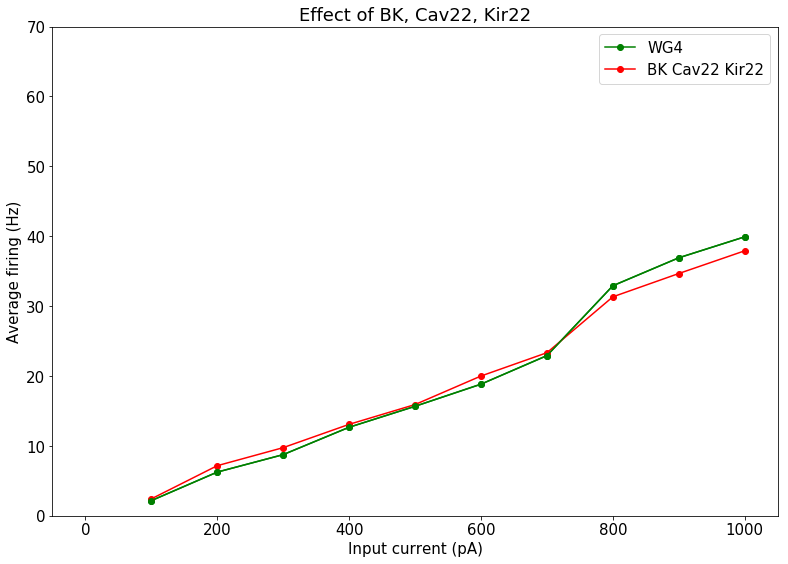

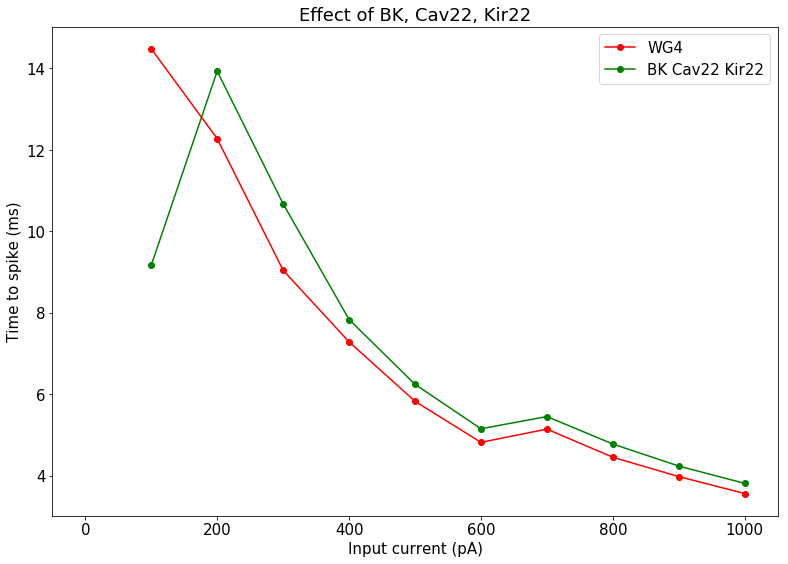

In [19]:
# RATES

plt.figure(1)
plt.plot(stim_curr, stim_3ch_fr, marker='o', color='green')
plt.plot(stim_curr, stim_fr, marker='o', color='red')
plt.plot(stim_curr, stim_3ch_fr, marker='o', color='green')


plt.xlabel('Input current (pA)')
plt.ylabel('Average firing (Hz)')
plt.xlim((-50, 1050))
plt.ylim((0, 70))
plt.legend(['WG4','BK Cav22 Kir22'])
plt.title('Effect of BK, Cav22, Kir22')


# TIME TO SPIKE

plt.figure(2)
plt.xlim((-50, 1050))
#plt.errorbar(stim_curr, stim_ttsp, stim_ttsp_std, marker='o', color='red')
#plt.errorbar(stim_curr, stim_3ch_ttsp, stim_3ch_ttsp_std, marker='o', color='green')
plt.plot(stim_curr, stim_ttsp, marker='o', color='red')
plt.plot(stim_curr, stim_3ch_ttsp, marker='o', color='green')


plt.xlabel('Input current (pA)')
plt.ylabel('Time to spike (ms)')
plt.legend(['WG4','BK Cav22 Kir22'])
plt.title('Effect of BK, Cav22, Kir22')


# BK

Text(0.5,1,'Effect of BK')

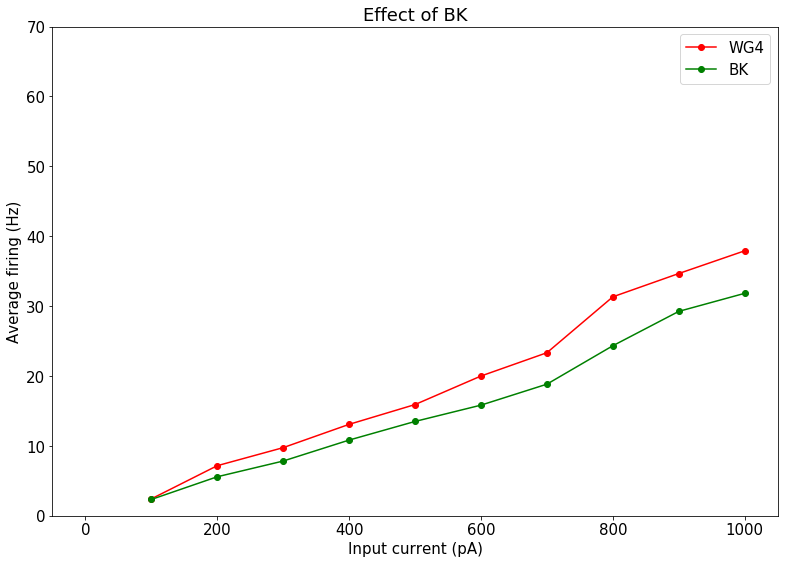

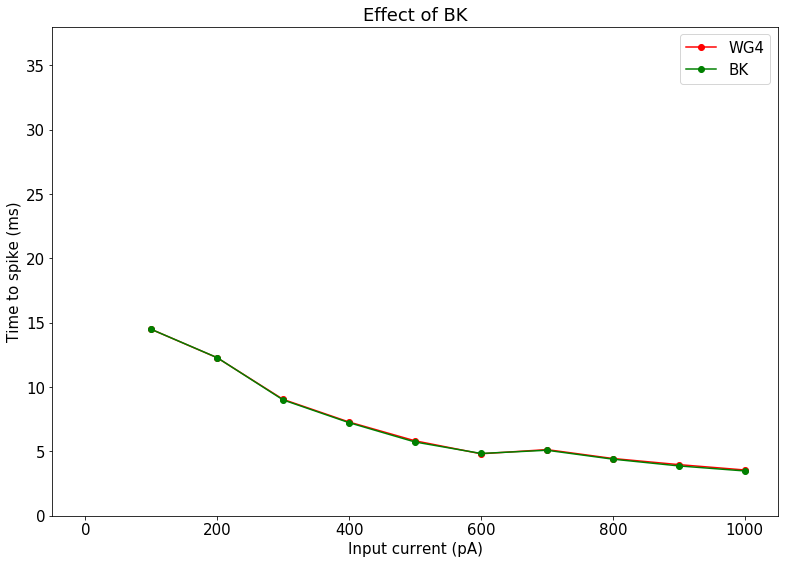

In [22]:

# RATES
plt.figure(1)
plt.plot(stim_curr, stim_fr, marker='o', color='red')
plt.plot(stim_curr, stim_BK_fr, marker='o', color='green')


plt.xlabel('Input current (pA)')
plt.ylabel('Average firing (Hz)')
plt.xlim((-50, 1050))
plt.ylim((0, 70))
plt.legend(['WG4','BK'])
plt.title('Effect of BK')


# TIME TO SPIKE

plt.figure(2)
plt.plot(stim_curr, stim_ttsp, marker='o', color='red')
plt.plot(stim_curr, stim_BK_ttsp, marker='o', color='green')


plt.xlabel('Input current (pA)')
plt.ylabel('Time to spike (ms)')
plt.xlim((-50, 1050))
plt.ylim((0, 38))
plt.legend(['WG4','BK'])
plt.title('Effect of BK')


# Cav2.2

Text(0.5,1,'Effect of Cav22')

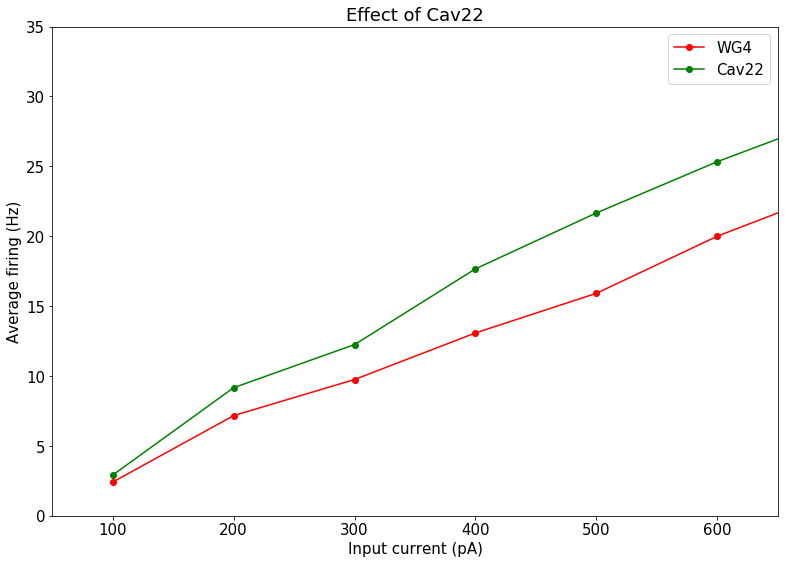

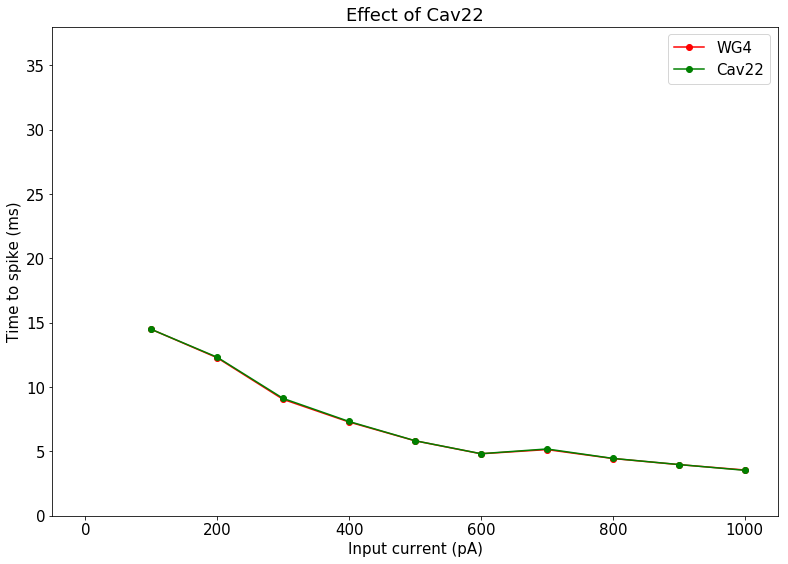

In [23]:

# RATES

plt.figure(1)
plt.plot(stim_curr, stim_fr, marker='o', color='red')
plt.plot(stim_curr, stim_Cav22_fr, marker='o', color='green')

plt.xlabel('Input current (pA)')
plt.ylabel('Average firing (Hz)')
plt.xlim((50, 650))
plt.ylim((0, 35))
plt.legend(['WG4','Cav22'])
plt.title('Effect of Cav22')

#plt.savefig('Cav22.pdf',format='pdf')

# TIME TO SPIKE
plt.figure(2)
plt.plot(stim_curr, stim_ttsp, marker='o', color='red')
plt.plot(stim_curr, stim_Cav22_ttsp, marker='o', color='green')

plt.xlabel('Input current (pA)')
plt.ylabel('Time to spike (ms)')
plt.xlim((-50, 1050))
plt.ylim((0, 38))
plt.legend(['WG4','Cav22'])
plt.title('Effect of Cav22')
